<a href="https://colab.research.google.com/github/sr6awi/ieee_fraud_detection/blob/main/notebooks/04_modeling_results_AUC_ROC_recalls_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from pathlib import Path
import pandas as pd
import joblib
from tensorflow import keras

# === SETUP PATHS ===
BASE_DIR = Path("/content/drive/MyDrive/ML_Projects/ieee-fraud-detection")
PROCESSED_DIR = BASE_DIR / "processed"
MODEL_DIR = BASE_DIR / "models"
RESULTS_DIR = BASE_DIR / "results"

# === LOAD SAVED ARTIFACTS ===
print("🔄 Loading saved model and scalers...")
final_model = keras.models.load_model(MODEL_DIR / "final_model.h5")
scaler_gnn = joblib.load(MODEL_DIR / "scaler_gnn.pkl")
scaler_tabnet = joblib.load(MODEL_DIR / "scaler_tabnet.pkl")

# === LOAD DATA ===
train = pd.read_csv(PROCESSED_DIR / "train_feature_engineered.csv")
test = pd.read_csv(PROCESSED_DIR / "test_feature_engineered.csv")

print("✅ Data and models ready!")

# === TRANSFORM TEST DATA ===
# === FEATURE LISTS (same as training) ===
GNN_FEATURES = [
    'TransactionAmt', 'TransactionDT', 'card1', 'card2', 'card1_count',
    'card1_fraud_rate', 'card2_fraud_rate', 'P_emaildomain_fraud_rate',
    'R_emaildomain_fraud_rate', 'addr1', 'dist1', 'ProductCD',
    'ProductCD_fraud_rate', 'transaction_hour', 'is_weekend', 'is_night',
    'TransactionAmt_log', 'email_domains_match', 'addr_match'
]

TABNET_FEATURES = [c for c in test.columns if c not in ['TransactionID']]


X_gnn_test_scaled = scaler_gnn.transform(test[GNN_FEATURES].fillna(0))
X_tabnet_test_scaled = scaler_tabnet.transform(test[TABNET_FEATURES].fillna(0))

# === CONTINUE WITH PREDICTION ===
test_predictions = final_model.predict(
    [X_gnn_test_scaled, X_tabnet_test_scaled],
    batch_size=1024,
    verbose=1
)

submission = pd.DataFrame({
    "TransactionID": test["TransactionID"],
    "isFraud": test_predictions.flatten()
})

submission_path = RESULTS_DIR / "submission_resume.csv"
submission.to_csv(submission_path, index=False)
print(f"✅ Predictions saved to {submission_path}")


🔄 Loading saved model and scalers...
✅ Data and models ready!


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


495/495 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
✅ Predictions saved to /content/drive/MyDrive/ML_Projects/ieee-fraud-detection/results/submission_resume.csv


In [3]:
import pandas as pd
from pathlib import Path

RESULTS_DIR = Path("/content/drive/MyDrive/ML_Projects/ieee-fraud-detection/results")
submission_path = RESULTS_DIR / "submission_resume.csv"

# Load predictions
submission = pd.read_csv(submission_path)
print("✅ Submission loaded successfully!")
print(submission.head())

# Basic summary
print("\n📊 Prediction Summary:")
print(f"Total rows: {len(submission):,}")
print(f"Mean predicted fraud probability: {submission['isFraud'].mean():.4f}")
print(f"Median predicted fraud probability: {submission['isFraud'].median():.4f}")

# Fraud threshold analysis
fraud_cutoff = 0.5
fraud_cases = (submission["isFraud"] > fraud_cutoff).sum()
print(f"\n🚨 Predicted Fraud Cases (prob > {fraud_cutoff}): {fraud_cases:,}")
print(f"Predicted Fraud Rate: {100 * fraud_cases / len(submission):.2f}%")


✅ Submission loaded successfully!
   TransactionID   isFraud
0        3663549  0.000247
1        3663550  0.000391
2        3663551  0.000260
3        3663552  0.000840
4        3663553  0.015925

📊 Prediction Summary:
Total rows: 506,691
Mean predicted fraud probability: 0.0883
Median predicted fraud probability: 0.0038

🚨 Predicted Fraud Cases (prob > 0.5): 29,891
Predicted Fraud Rate: 5.90%


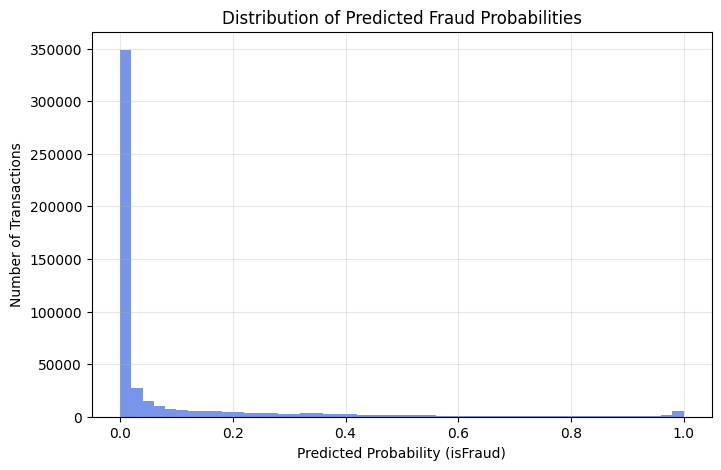

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(submission["isFraud"], bins=50, color='royalblue', alpha=0.7)
plt.title("Distribution of Predicted Fraud Probabilities")
plt.xlabel("Predicted Probability (isFraud)")
plt.ylabel("Number of Transactions")
plt.grid(True, alpha=0.3)
plt.show()


📊 VALIDATION SET EVALUATION

🔮 Generating validation predictions...
3691/3691 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step

🏆 Final Validation AUC: 0.955979

📋 Classification Report:
              precision    recall  f1-score   support

       Legit     0.9924    0.9513    0.9714    113975
       Fraud     0.3731    0.7997    0.5088      4133

    accuracy                         0.9460    118108
   macro avg     0.6828    0.8755    0.7401    118108
weighted avg     0.9707    0.9460    0.9552    118108



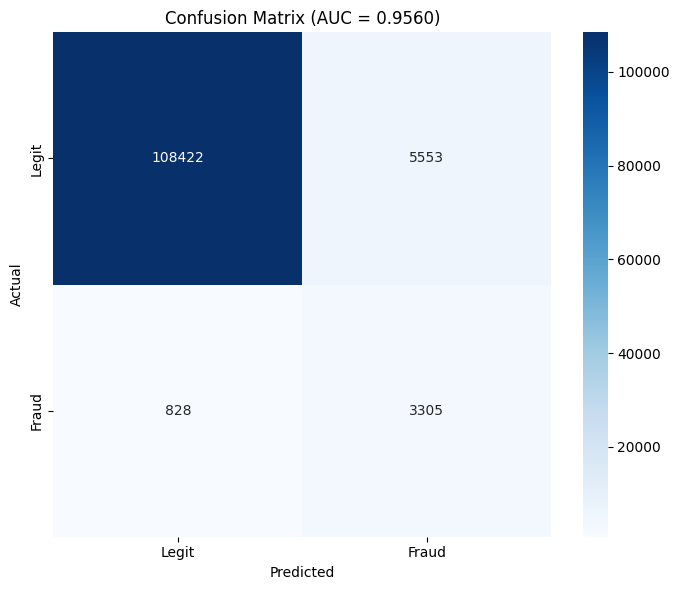


✅ Evaluation complete!


In [5]:
# =====================================================================
# 📊 VALIDATION SET EVALUATION (NO RETRAINING)
# =====================================================================
import numpy as np
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("\n" + "="*70)
print("📊 VALIDATION SET EVALUATION")
print("="*70)

# === Recreate validation split (same seed & stratify as before) ===
from sklearn.model_selection import train_test_split

# Use the same split parameters used during training
X_gnn = train[GNN_FEATURES].fillna(0).values
X_tabnet = train[TABNET_FEATURES].fillna(0).values
y = train["isFraud"].values

X_gnn_train, X_gnn_val, X_tabnet_train, X_tabnet_val, y_train_final, y_val_final = train_test_split(
    X_gnn, X_tabnet, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Apply scalers (already fitted)
X_gnn_val_scaled = scaler_gnn.transform(X_gnn_val)
X_tabnet_val_scaled = scaler_tabnet.transform(X_tabnet_val)

# === Run inference on validation set ===
print("\n🔮 Generating validation predictions...")
val_predictions = final_model.predict([X_gnn_val_scaled, X_tabnet_val_scaled], verbose=1)
val_pred_binary = (val_predictions > 0.5).astype(int).flatten()

# === Metrics ===
val_auc_final = roc_auc_score(y_val_final, val_predictions)
print(f"\n🏆 Final Validation AUC: {val_auc_final:.6f}")

print("\n📋 Classification Report:")
print(classification_report(y_val_final, val_pred_binary, target_names=["Legit", "Fraud"], digits=4))

# === Confusion Matrix ===
cm = confusion_matrix(y_val_final, val_pred_binary)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Legit", "Fraud"], yticklabels=["Legit", "Fraud"])
plt.title(f"Confusion Matrix (AUC = {val_auc_final:.4f})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

print("\n✅ Evaluation complete!")



📊 ROC & PRECISION–RECALL CURVES


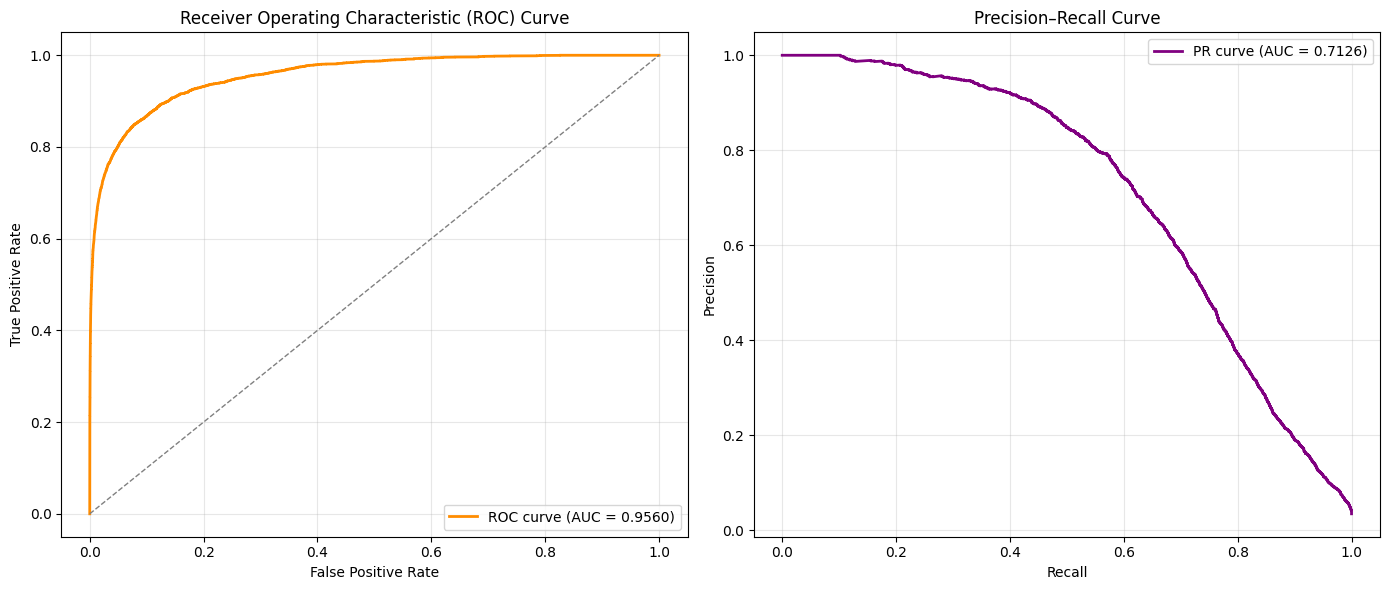


🏆 ROC-AUC: 0.955979
🏆 PR-AUC : 0.712637

✅ Curves plotted successfully!


In [6]:
# =====================================================================
# 📈 ROC & PRECISION-RECALL CURVES
# =====================================================================
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
import numpy as np

print("\n" + "="*70)
print("📊 ROC & PRECISION–RECALL CURVES")
print("="*70)

# === Compute metrics ===
fpr, tpr, _ = roc_curve(y_val_final, val_predictions)
precision, recall, _ = precision_recall_curve(y_val_final, val_predictions)

roc_auc = auc(fpr, tpr)
pr_auc = auc(recall, precision)

# === Plot both curves ===
plt.figure(figsize=(14, 6))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)

# Precision–Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='purple', lw=2, label=f'PR curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.legend(loc="upper right")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n🏆 ROC-AUC: {roc_auc:.6f}")
print(f"🏆 PR-AUC : {pr_auc:.6f}")
print("\n✅ Curves plotted successfully!")



⚙️ OPTIMAL THRESHOLD SEARCH (based on validation set)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


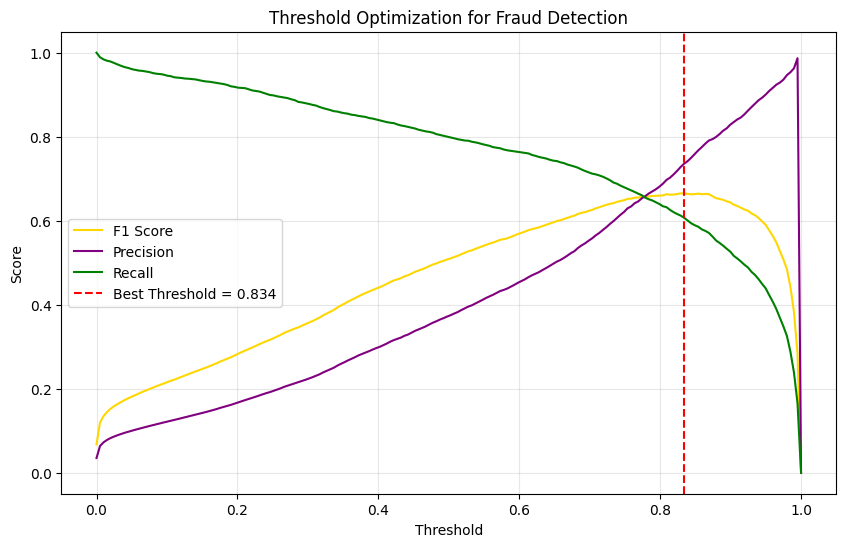


🏆 Best Threshold Found: 0.834
   F1-Score:  0.6652
   Precision: 0.7359
   Recall:    0.6068


In [7]:
from sklearn.metrics import f1_score, precision_score, recall_score

print("\n" + "="*70)
print("⚙️ OPTIMAL THRESHOLD SEARCH (based on validation set)")
print("="*70)

thresholds = np.linspace(0, 1, 200)
f1_scores, precisions, recalls = [], [], []

for t in thresholds:
    preds = (val_predictions > t).astype(int)
    f1_scores.append(f1_score(y_val_final, preds))
    precisions.append(precision_score(y_val_final, preds))
    recalls.append(recall_score(y_val_final, preds))

# Find the best F1 threshold
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]
best_precision = precisions[best_idx]
best_recall = recalls[best_idx]

# Plot F1, Precision, Recall vs Threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label="F1 Score", color="gold")
plt.plot(thresholds, precisions, label="Precision", color="purple")
plt.plot(thresholds, recalls, label="Recall", color="green")
plt.axvline(x=best_threshold, color="red", linestyle="--", label=f"Best Threshold = {best_threshold:.3f}")
plt.title("Threshold Optimization for Fraud Detection")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print(f"\n🏆 Best Threshold Found: {best_threshold:.3f}")
print(f"   F1-Score:  {best_f1:.4f}")
print(f"   Precision: {best_precision:.4f}")
print(f"   Recall:    {best_recall:.4f}")

In [9]:
# =====================================================================
# 📦 SAVE PRODUCTION INFERENCE BUNDLE (FIXED VERSION)
# =====================================================================
import pickle
from datetime import datetime

print("\n" + "="*70)
print("📦 SAVING INFERENCE BUNDLE FOR DEPLOYMENT")
print("="*70)

# Recreate CONFIG (same as training)
CONFIG = {
    'batch_size': 1024,
    'epochs': 50,
    'learning_rate': 0.001,
    'patience': 10,
    'n_folds': 5,
    'use_class_weights': True,
    'save_best_only': True
}

# Create bundle dictionary
inference_bundle = {
    "model_path": str(MODEL_DIR / "final_model.h5"),
    "scaler_gnn": scaler_gnn,
    "scaler_tabnet": scaler_tabnet,
    "threshold": float(best_threshold),
    "config": CONFIG,
    "metrics": {
        "roc_auc": float(roc_auc),
        "pr_auc": float(pr_auc),
        "f1": float(best_f1),
        "precision": float(best_precision),
        "recall": float(best_recall)
    },
    "export_date": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
}

# Save bundle to disk
bundle_path = MODEL_DIR / "fraud_inference_bundle.pkl"
with open(bundle_path, "wb") as f:
    pickle.dump(inference_bundle, f)

print(f"✅ Inference bundle saved: {bundle_path}")
print("📁 Contents:")
for k, v in inference_bundle["metrics"].items():
    print(f"   {k:12}: {v:.4f}")

print("\n🧠 Threshold used for production inference:", inference_bundle["threshold"])
print("📦 You can now load this bundle in any environment to make predictions.")



📦 SAVING INFERENCE BUNDLE FOR DEPLOYMENT
✅ Inference bundle saved: /content/drive/MyDrive/ML_Projects/ieee-fraud-detection/models/fraud_inference_bundle.pkl
📁 Contents:
   roc_auc     : 0.9560
   pr_auc      : 0.7126
   f1          : 0.6652
   precision   : 0.7359
   recall      : 0.6068

🧠 Threshold used for production inference: 0.8341708542713568
📦 You can now load this bundle in any environment to make predictions.


In [10]:
# =====================================================================
# 🧠 LOAD INFERENCE BUNDLE & RUN PREDICTIONS ON NEW DATA
# =====================================================================
import pickle
import pandas as pd
from tensorflow import keras

print("\n" + "="*70)
print("🧠 LOADING FRAUD INFERENCE BUNDLE")
print("="*70)

# === LOAD BUNDLE ===
bundle_path = MODEL_DIR / "fraud_inference_bundle.pkl"
with open(bundle_path, "rb") as f:
    bundle = pickle.load(f)

# Extract components
model = keras.models.load_model(bundle["model_path"])
scaler_gnn = bundle["scaler_gnn"]
scaler_tabnet = bundle["scaler_tabnet"]
threshold = bundle["threshold"]

print(f"✅ Model loaded with threshold = {threshold:.3f}")
print(f"Metrics snapshot: AUC={bundle['metrics']['roc_auc']:.3f}, F1={bundle['metrics']['f1']:.3f}")

# === LOAD NEW TRANSACTION DATA (example) ===
# Replace this path with your incoming data source
new_data = pd.read_csv(PROCESSED_DIR / "test_feature_engineered.csv").head(5)  # just a few for demo

# Define feature sets (must match training)
GNN_FEATURES = [
    'TransactionAmt', 'TransactionDT', 'card1', 'card2', 'card1_count',
    'card1_fraud_rate', 'card2_fraud_rate', 'P_emaildomain_fraud_rate',
    'R_emaildomain_fraud_rate', 'addr1', 'dist1', 'ProductCD',
    'ProductCD_fraud_rate', 'transaction_hour', 'is_weekend', 'is_night',
    'TransactionAmt_log', 'email_domains_match', 'addr_match'
]
TABNET_FEATURES = [c for c in new_data.columns if c not in ['TransactionID']]

# Scale features
X_gnn_new = scaler_gnn.transform(new_data[GNN_FEATURES].fillna(0))
X_tabnet_new = scaler_tabnet.transform(new_data[TABNET_FEATURES].fillna(0))

# Predict fraud probabilities
probs = model.predict([X_gnn_new, X_tabnet_new], verbose=0).flatten()

# Apply threshold
preds = (probs >= threshold).astype(int)

# Combine results
results = pd.DataFrame({
    "TransactionID": new_data["TransactionID"],
    "Fraud_Probability": probs,
    "Predicted_Label": preds
})

print("\n✅ Sample Predictions:")
print(results)

# Save predictions (optional)
results.to_csv(RESULTS_DIR / "sample_predictions.csv", index=False)
print(f"\n💾 Saved: {RESULTS_DIR / 'sample_predictions.csv'}")



🧠 LOADING FRAUD INFERENCE BUNDLE
✅ Model loaded with threshold = 0.834
Metrics snapshot: AUC=0.956, F1=0.665


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(



✅ Sample Predictions:
   TransactionID  Fraud_Probability  Predicted_Label
0        3663549           0.000247                0
1        3663550           0.000391                0
2        3663551           0.000260                0
3        3663552           0.000840                0
4        3663553           0.015925                0

💾 Saved: /content/drive/MyDrive/ML_Projects/ieee-fraud-detection/results/sample_predictions.csv
